In [96]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [97]:
import numpy as np
import pandas as pd

In [98]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [99]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [100]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [101]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [102]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [103]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [104]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

C:\Users\dinhh\New folder\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


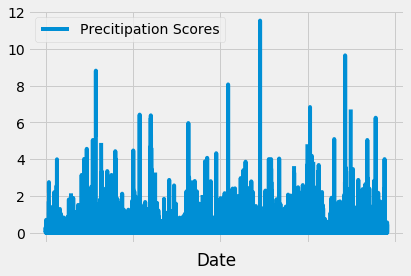

In [105]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
date_prev_year = dt.date(28,8,23) - dt.timedelta(days = 365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= date_prev_year).all()
results

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(results, columns = ['Date', 'Precitipation Scores'])

# Sort the dataframe by date

df.set_index(df['Date'], inplace = True)
df = df.sort_values('Date')
# Use Pandas Plotting with Matplotlib to plot the data

df.plot()


![precipitation](Images/precipitation.png)

In [106]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precitipation Scores
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


![describe](Images/describe.png)

In [107]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [108]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
recorded = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

recorded

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [109]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_temp = []
max_temp = []
avg_temp = []
station = []
for i in range(0, len(recorded)):
    station.append(recorded[i][0])
    new_record = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == station[i]).all()
    min_temp.append(new_record[0][0])
    max_temp.append(new_record[0][1])
    avg_temp.append(new_record[0][2])
    

Temp_df = pd.DataFrame({"Station": station,"Min Temp": min_temp, "Max Temp": max_temp, "Avg Temp": avg_temp})

Temp_df



,Station,Min Temp,Max Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781
1,USC00519397,56.0,87.0,74.553231
2,USC00513117,59.0,85.0,72.689184
3,USC00519523,56.0,85.0,74.543649
4,USC00516128,58.0,84.0,70.915008
5,USC00514830,58.0,85.0,74.873297
6,USC00511918,53.0,87.0,71.615968
7,USC00517948,58.0,87.0,74.684402
8,USC00518838,58.0,83.0,72.724070


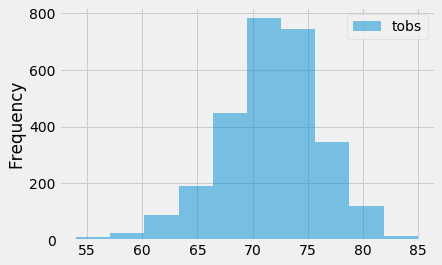

In [110]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from pandas.plotting import table

results_2 = session.query(Measurement.tobs).filter(Measurement.date >= date_prev_year).\
filter(Measurement.station == "USC00519281").all()


df = pd.DataFrame(results_2, columns = ['tobs'])
df.plot.hist(alpha = 0.5)

![precipitation](Images/station-histogram.png)

In [112]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [113]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_starts = dt.date(2018,3,3) - dt.timedelta(days = 365)
trip_ends = dt.date(2018,3,5) - dt.timedelta(days = 365)

t_min= calc_temps(trip_starts, trip_ends)[0][0]
t_max= calc_temps(trip_starts, trip_ends)[0][1]
t_avg= calc_temps(trip_starts, trip_ends)[0][2]
print(t_min, t_max, t_avg)



68.0 72.8125 78.0


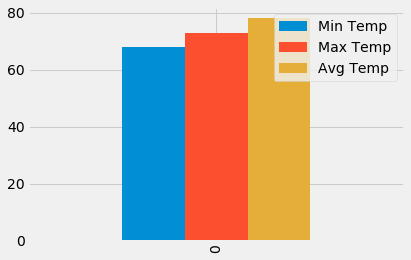

In [114]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


df = pd.DataFrame({"Min Temp": [t_min], "Max Temp": [t_max], "Avg Temp": [t_avg]})
df.plot.bar()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
